# Convolutional Autoencoders

In this file, I'm going to create a Convolutional Autoencoder to be able to classify handwritten digits from the MNIST dataset.

It is recommended that you run this file on Google Colab so that you have access to a GPU. Without a GPU, this code may not run.

## Preliminaries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# In case you are fortunate enough to have access to a GPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset: MNIST

In [ ]:
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))

In [3]:
ds = torch.utils.data.Subset(ds_full, range(1024))

In [4]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

In [ ]:
with torch.no_grad():
    x,t = ds.__getitem__(130)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

## Creating `DataLoader`s

In [6]:
# Batched, for training
batch_size_train = 10
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [7]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# `ConvAE` class

The ConvAE class is designed to handle MNIST images and be able to classify incoming images as one of the 10 digits using an encoder and decoder.

These two operations are the inverse of each other.

In [212]:
class ConvAE(nn.Module):
    '''
     net = ConvAE(img_size=28, embedding_dim=3)

     Create a convolutional autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.

     Inputs:
       img_size       size of input images, [1, img_size, img_size]
       embedding_dim  number of nodes in embedding (latent) layer

     Usage:
       net = ConvAE()
       y = net(x)
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=3):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(img_size * img_size, 3),
            nn.Tanh(), # ensures that its between -1 and 1
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, img_size*img_size),
            nn.Unflatten(1, (1, img_size, img_size)),
            nn.ReLU(),
            nn.ConvTranspose2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(28, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(), # ensures that its from 0 to 1
        )


    def encode(self, x):
        return self.encoder(x) 


    def decode(self, x):
        return self.decoder(x) 


    def forward(self, x):
        self.h = self.encoder(x)
        return self.decoder(self.h) 


# Train the network

In [213]:
net = ConvAE(img_size=img_size, embedding_dim=3)

100%|██████████| 1000/1000 [30:01<00:00,  1.80s/it]


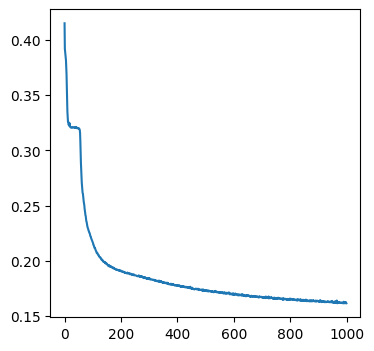

In [214]:
from statistics import mean
# Train it
def learn(net, ds, epochs=500):
  losses = []
  for epoch in tqdm(range(epochs)):
    loss_vals = []
    for batch in ds:
      x, t = batch
      y = net(x)
      loss = loss_fcn(y, x)
      optim.zero_grad()
      loss.backward()
      optim.step()
      loss_vals.append(loss.item())
    losses.append(mean(loss_vals))

  plt.figure(figsize=(4, 4))
  plt.plot(losses)
  return losses

loss_fcn = nn.BCELoss(reduction='mean')
optim = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

loss = learn(net, train_dl, epochs=1000)

# Latent space

In [218]:
colour_options = ['k', 'tab:brown', 'r', 'orange', 'gold', 'lawngreen', 'forestgreen', 'blue', 'mediumpurple', 'gray']

In [219]:
# Compute the latent-space representation for all the samples.
data, t = next(iter(train_all))
h_all = net.encode(data)
np_arr = h_all.detach().numpy()
targets = t.detach().numpy()
x = []
y = []
z = []
cols = []
for i in range(len(np_arr)):
  x.append(np_arr[i][0])
  y.append(np_arr[i][1])
  z.append(np_arr[i][2])
  cols.append(targets[i])

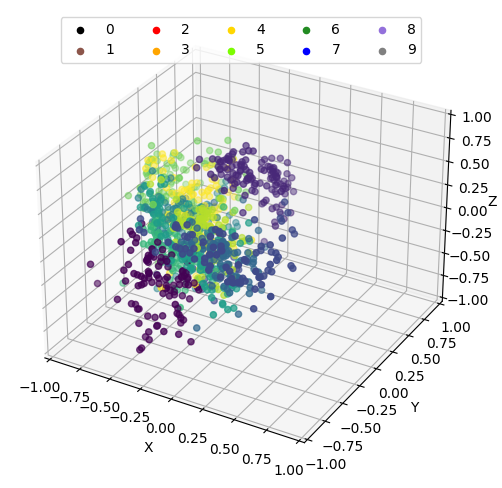

In [220]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=cols)
ax.scatter(-10, -10, 0, c=colour_options[0], label="0")
ax.scatter(-10, -10, 1, c=colour_options[1], label="1")
ax.scatter(-10, -10, 2, c=colour_options[2], label="2")
ax.scatter(-10, -10, 3, c=colour_options[3], label="3")
ax.scatter(-10, -10, 1, c=colour_options[4], label="4")
ax.scatter(-10, -10, 1, c=colour_options[5], label="5")
ax.scatter(-10, -10, 1, c=colour_options[6], label="6")
ax.scatter(-10, -10, 1, c=colour_options[7], label="7")
ax.scatter(-10, -10, 1, c=colour_options[8], label="8")
ax.scatter(-10, -10, 1, c=colour_options[9], label="9")
ax.legend(loc="upper center", ncol=5)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.zaxis.labelpad=-0.7
plt.show()

# Plot reconstructed digit images

In [333]:
# the pictures chosen
x0, t0 = ds.__getitem__(1)
picture0 = net.decode(net.encode(x0))
x1, t1 = ds.__getitem__(128)
picture1 = net.decode(net.encode(x1))
x2, t2 = ds.__getitem__(220) # or 76
picture2 = net.decode(net.encode(x2))
x3,t3 = ds.__getitem__(98)
picture3 = net.decode(net.encode(x3))
x4,t4 = ds.__getitem__(461)
picture4 = net.decode(net.encode(x4))
x5,t5 = ds.__getitem__(474)
picture5 = net.decode(net.encode(x5))
x6,t6 = ds.__getitem__(498)
picture6 = net.decode(net.encode(x6))
x7,t7 = ds.__getitem__(223)
picture7 = net.decode(net.encode(x7))
x8,t8 = ds.__getitem__(456)
picture8 = net.decode(net.encode(x8))
x9,t9 = ds.__getitem__(226)
picture9 = net.decode(net.encode(x9))

Digit Reconstructions



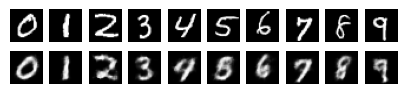

In [335]:
f, axarr = plt.subplots(2, 10, figsize=(5, 1))
ax = axarr.ravel()

ax[0].imshow(x0.squeeze().detach().numpy(), cmap='gray')
ax[1].imshow(x1.squeeze().detach().numpy(), cmap='gray')
ax[2].imshow(x2.squeeze().detach().numpy(), cmap='gray')
ax[3].imshow(x3.squeeze().detach().numpy(), cmap='gray')
ax[4].imshow(x4.squeeze().detach().numpy(), cmap='gray')
ax[5].imshow(x5.squeeze().detach().numpy(), cmap='gray')
ax[6].imshow(x6.squeeze().detach().numpy(), cmap='gray')
ax[7].imshow(x7.squeeze().detach().numpy(), cmap='gray')
ax[8].imshow(x8.squeeze().detach().numpy(), cmap='gray')
ax[9].imshow(x9.squeeze().detach().numpy(), cmap='gray')

ax[10].imshow(picture0.squeeze().detach().numpy(), cmap='gray')
ax[11].imshow(picture1.squeeze().detach().numpy(), cmap='gray')
ax[12].imshow(picture2.squeeze().detach().numpy(), cmap='gray')
ax[13].imshow(picture3.squeeze().detach().numpy(), cmap='gray')
ax[14].imshow(picture4.squeeze().detach().numpy(), cmap='gray')
ax[15].imshow(picture5.squeeze().detach().numpy(), cmap='gray')
ax[16].imshow(picture6.squeeze().detach().numpy(), cmap='gray')
ax[17].imshow(picture7.squeeze().detach().numpy(), cmap='gray')
ax[18].imshow(picture8.squeeze().detach().numpy(), cmap='gray')
ax[19].imshow(picture9.squeeze().detach().numpy(), cmap='gray')

for i in range(20):
  ax[i].axis("off")